# Function interpolation - simulation study 

This notebook runs a simple simulation study comparing the performance of multidimensional interpolation methods.

Ultimately, the goal is to implement interpolation methods in *respy*, an open-source Python package for the estimation of dynamic discrete-choice models.

# Motivation




...

# Theoretical Framework

...

# Simulation study

## Import necessary packages:

In [5]:
%load_ext autoreload
%matplotlib inline

import pickle
import sys
import os

cwd = os.getcwd()
sys.path.insert(0, cwd + "\src")

import matplotlib.pyplot as plt
import numpy as np
from time import time

from src.functions_to_approximate import borehole_numba as borehole
from src.interpolate import get_data
from src.interpolate import get_grid
from src.interpolate import interpolate_linear
from src.interpolate import interpolate_smolyak
from src.interpolate import interpolate_spline
from src.interpolate import rmse as root_mean_squared_error
from src.parameters import study_params
from src.parameters import interp_params


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Benchmark: Smolyak interpolation

### Set parameters

In [9]:
study_params["controls"] = {
    "load data": False,
    "method": "smolyak",
    "grid size": "small",
    "variables": [2, 3, 4, 5, 6, 7, 8],
    "function to approximate": borehole,
}

### Execute interpolation

In [11]:
# load parameters
method = study_params["controls"]["method"]
func = study_params["controls"]["function to approximate"]
grid_size = study_params["controls"]["grid size"]
iterations = study_params[method]["mu"]
interpolator = study_params[method]["interpolator"]

# initiate dict to store results
results = {}
results[method] = {"rmse": {}, "runtime": {}, "gridpoints": {}}

for n_vars in study_params["controls"]["variables"]:

    # generate grid
    n_gridpoints = study_params["grid"]["n_gridpoints"][grid_size]
    grid_min = study_params["grid"]["lower bounds"][:n_vars]
    grid_max = study_params["grid"]["upper bounds"][:n_vars]
    dims_state_grid = np.array(object=[n_gridpoints] * n_vars, dtype=int,)
    n_states = dims_state_grid.prod()
    grid = get_grid(dims_state_grid, grid_min, grid_max)
    index = np.array(object=range(n_states))

    # load or calculate actuals
    _, results_calc = get_data(func, grid_size, n_vars, dims_state_grid, grid)

    # initiate objects to store results
    rmse_tmp = []
    runtime_tmp = []
    n_gridpoints_effective_tmp = []

    # iterate over settings
    for iteration in range(len(iterations)):
        print(f"dimension: {n_vars}; iteration: {iteration + 1}")

        # adjust interpolation parameters
        if study_params["controls"]["method"] == "linear":
            interp_params["linear"]["interpolation_points"] = study_params[
                "spline"
            ]["interpolation_points"][iteration]
        elif study_params["controls"]["method"] == "spline":
            interp_params["spline"]["interpolation_points"] = study_params[
                "spline"
            ]["interpolation_points"][iteration]
        elif study_params["controls"]["method"] == "smolyak":
            interp_params["smolyak"]["mu"] = study_params["smolyak"]["mu"][
                iteration
            ]

        # interpolate and capture computation time
        start = time()
        results_interp, n_gridpoints_effective = interpolator(
            grid, func, interp_params
        )
        stop = time()

        # assess interpolation accuracy
        rmse_iter = root_mean_squared_error(results_interp, results_calc)

        # print and store results
        print("root mean squared error: " + method + f" {rmse_iter}")
        print("computation time: " + method + " {}".format(stop - start))
        print(f"gridpoints: {n_gridpoints_effective}")

        rmse_tmp.append(rmse_iter)
        runtime_tmp.append(stop - start)
        n_gridpoints_effective_tmp.append(n_gridpoints_effective)

    results[method]["rmse"][n_vars] = np.array(object=rmse_tmp)
    results[method]["runtime"][n_vars] = np.array(object=runtime_tmp)
    results[method]["gridpoints"][n_vars] = np.array(
        object=n_gridpoints_effective_tmp
    )

dimension: 2; iteration: 1
root mean squared error: smolyak 7.5859324023803255e-06
computation time: smolyak 0.0023109912872314453
gridpoints: 5
dimension: 2; iteration: 2
root mean squared error: smolyak 2.2028415067855797e-07
computation time: smolyak 0.003515005111694336
gridpoints: 13
dimension: 2; iteration: 3
root mean squared error: smolyak 4.917078991684836e-09
computation time: smolyak 0.00408482551574707
gridpoints: 29
dimension: 3; iteration: 1
root mean squared error: smolyak 1.0624420845658901e-05
computation time: smolyak 0.009972572326660156
gridpoints: 7
dimension: 3; iteration: 2
root mean squared error: smolyak 3.097104978764495e-07
computation time: smolyak 0.010970592498779297
gridpoints: 25
dimension: 3; iteration: 3
root mean squared error: smolyak 6.953755734777794e-09
computation time: smolyak 0.009979248046875
gridpoints: 69
dimension: 4; iteration: 1
root mean squared error: smolyak 0.01533831885880831
computation time: smolyak 0.03191971778869629
gridpoints: 

In [14]:
print(results["smolyak"]["rmse"])
print(results["smolyak"]["runtime"])

{2: array([7.58593240e-06, 2.20284151e-07, 4.91707899e-09]), 3: array([1.06244208e-05, 3.09710498e-07, 6.95375573e-09]), 4: array([0.01533832, 0.00548674, 0.00187544]), 5: array([7.98591366, 0.03113062, 0.01121628]), 6: array([10.20123699,  1.17965164,  0.01986601]), 7: array([26.98736627,  5.94507315,  0.67159651]), 8: array([26.96188369,  5.93748454,  0.67174501])}
{2: array([0.00231099, 0.00351501, 0.00408483]), 3: array([0.00997257, 0.01097059, 0.00997925]), 4: array([0.03191972, 0.0301435 , 0.0508635 ]), 5: array([0.19451332, 0.14912629, 0.24609375]), 6: array([1.046206  , 0.84713197, 1.13297105]), 7: array([4.89990044, 4.74185514, 5.93916345]), 8: array([27.3385129 , 30.97149682, 51.27688551])}


# Plot results

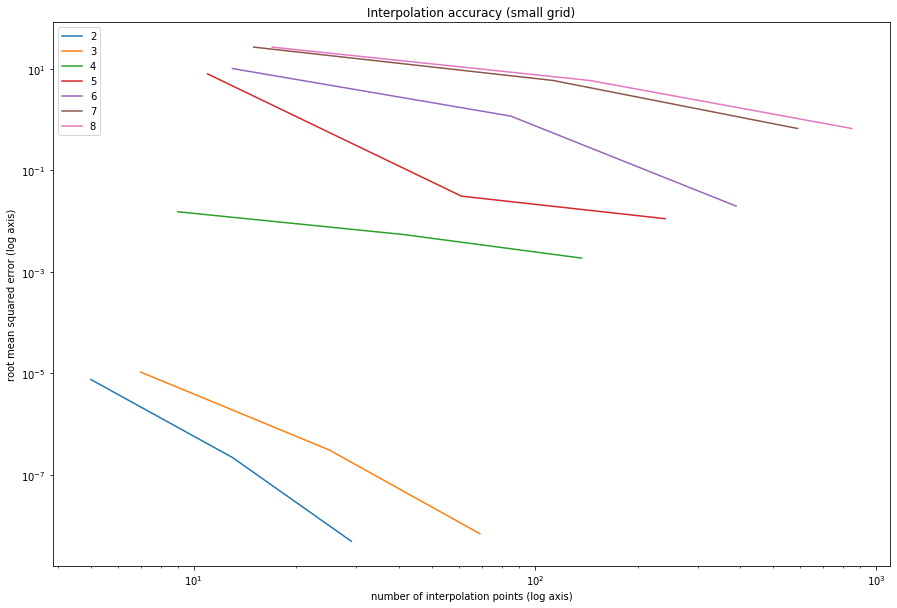

In [22]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

plot_legend = []
plot_x = []
plot_y = []
for n_vars in study_params["controls"]["variables"]:
    plot_legend.append(n_vars)
    plot_x.append(results[method]["gridpoints"][n_vars])
    plot_y.append(results[method]["rmse"][n_vars])

for idx in range(len(study_params["controls"]["variables"])):
    plt.plot(plot_x[idx], plot_y[idx])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("number of interpolation points (log axis)")
plt.ylabel("root mean squared error (log axis)")
plt.legend(plot_legend)
plt.title("Interpolation accuracy (" + grid_size + " grid)")
plt.show()

# References

...